In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.spatial import cKDTree
import matplotlib

In [2]:
def plot_cube(x, unit_label, save_name):
    resolution = np.shape(x)[0]
    voxel_centers = np.reshape(grid_coords, (resolution, resolution, resolution, 3))[0][:,0,0]
    voxel_centers = np.array([voxel_centers, voxel_centers, voxel_centers])
    z_slice_min, z_slice_max = [-10,10]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.sum(x[:,:,mask], axis=2)
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$', size=20)
    plt.ylabel('$y$', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title(save_name, size=20)
    plt.savefig("../visuals/demo-"+save_name+".svg", bbox_inches='tight')
    plt.show()

In [3]:
cube_length       = 20   # kpc
voxel_resolution  = 2**5 # bins / kpc

bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2

xx_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[0]#.astype(np.float32)
yy_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[1]#.astype(np.float32)
zz_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[2]#.astype(np.float32)

# These two are equivalent:
# grid_c = np.dstack(np.array([xx_c,yy_c, zz_c])).reshape(-1,3)
grid_coords = np.vstack((xx_c.ravel(), yy_c.ravel(), zz_c.ravel())).T

In [4]:
sun_mw_distance_kpc = 8
NSIDE = 2**6
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)

# array of theta, phi, for each pixel
theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))
dl =  0.1
l_min, l_max = 0, 10
l_list = np.arange(l_min,l_max,dl)[:, np.newaxis]
# 2D array of distance elements along each sightline
l = np.ones((len(l_list),len(theta))) * l_list

# (l,theta,phi) -> (x,y,z)
x = l * np.sin(theta) * np.cos(phi) - sun_mw_distance_kpc
y = l * np.sin(theta) * np.sin(phi)
z = l * np.cos(theta)

In [5]:
outside_cube = (np.abs(x) > cube_length/2) | (np.abs(y) > cube_length/2) | (np.abs(z) > cube_length/2)

In [6]:
print(f">> generating cKDTree")
tree_points = cKDTree(grid_coords) # Also apparently possible with BallTree
 
cube_indexes = np.zeros(np.shape(x))
# for each radius element
for i in range(np.shape(x)[0]):
    # find the nearest cube for all angles
    cube_indexes[i,:] = tree_points.query(np.array([x[i,:],y[i,:],z[i,:]]).T)[1]
    print((i+1)/np.shape(x)[0] * 100, end="\r")

cube_indexes = np.array(np.round(cube_indexes), dtype = np.int32)

>> generating cKDTree


In [220]:
distances = np.sqrt(np.sum(grid_coords**2, axis=1))
distances = np.reshape(distances, (voxel_resolution, voxel_resolution, voxel_resolution))
cube = np.exp(-distances)

cube_integral  = np.reshape(cube,(voxel_resolution**3))
cube_integral_paths = cube_integral[cube_indexes]
cube_integral_paths[outside_cube] = 0
f_aqn = np.sum(cube_integral_paths, axis=0) / (4*np.pi) * (dl)# * dOmega

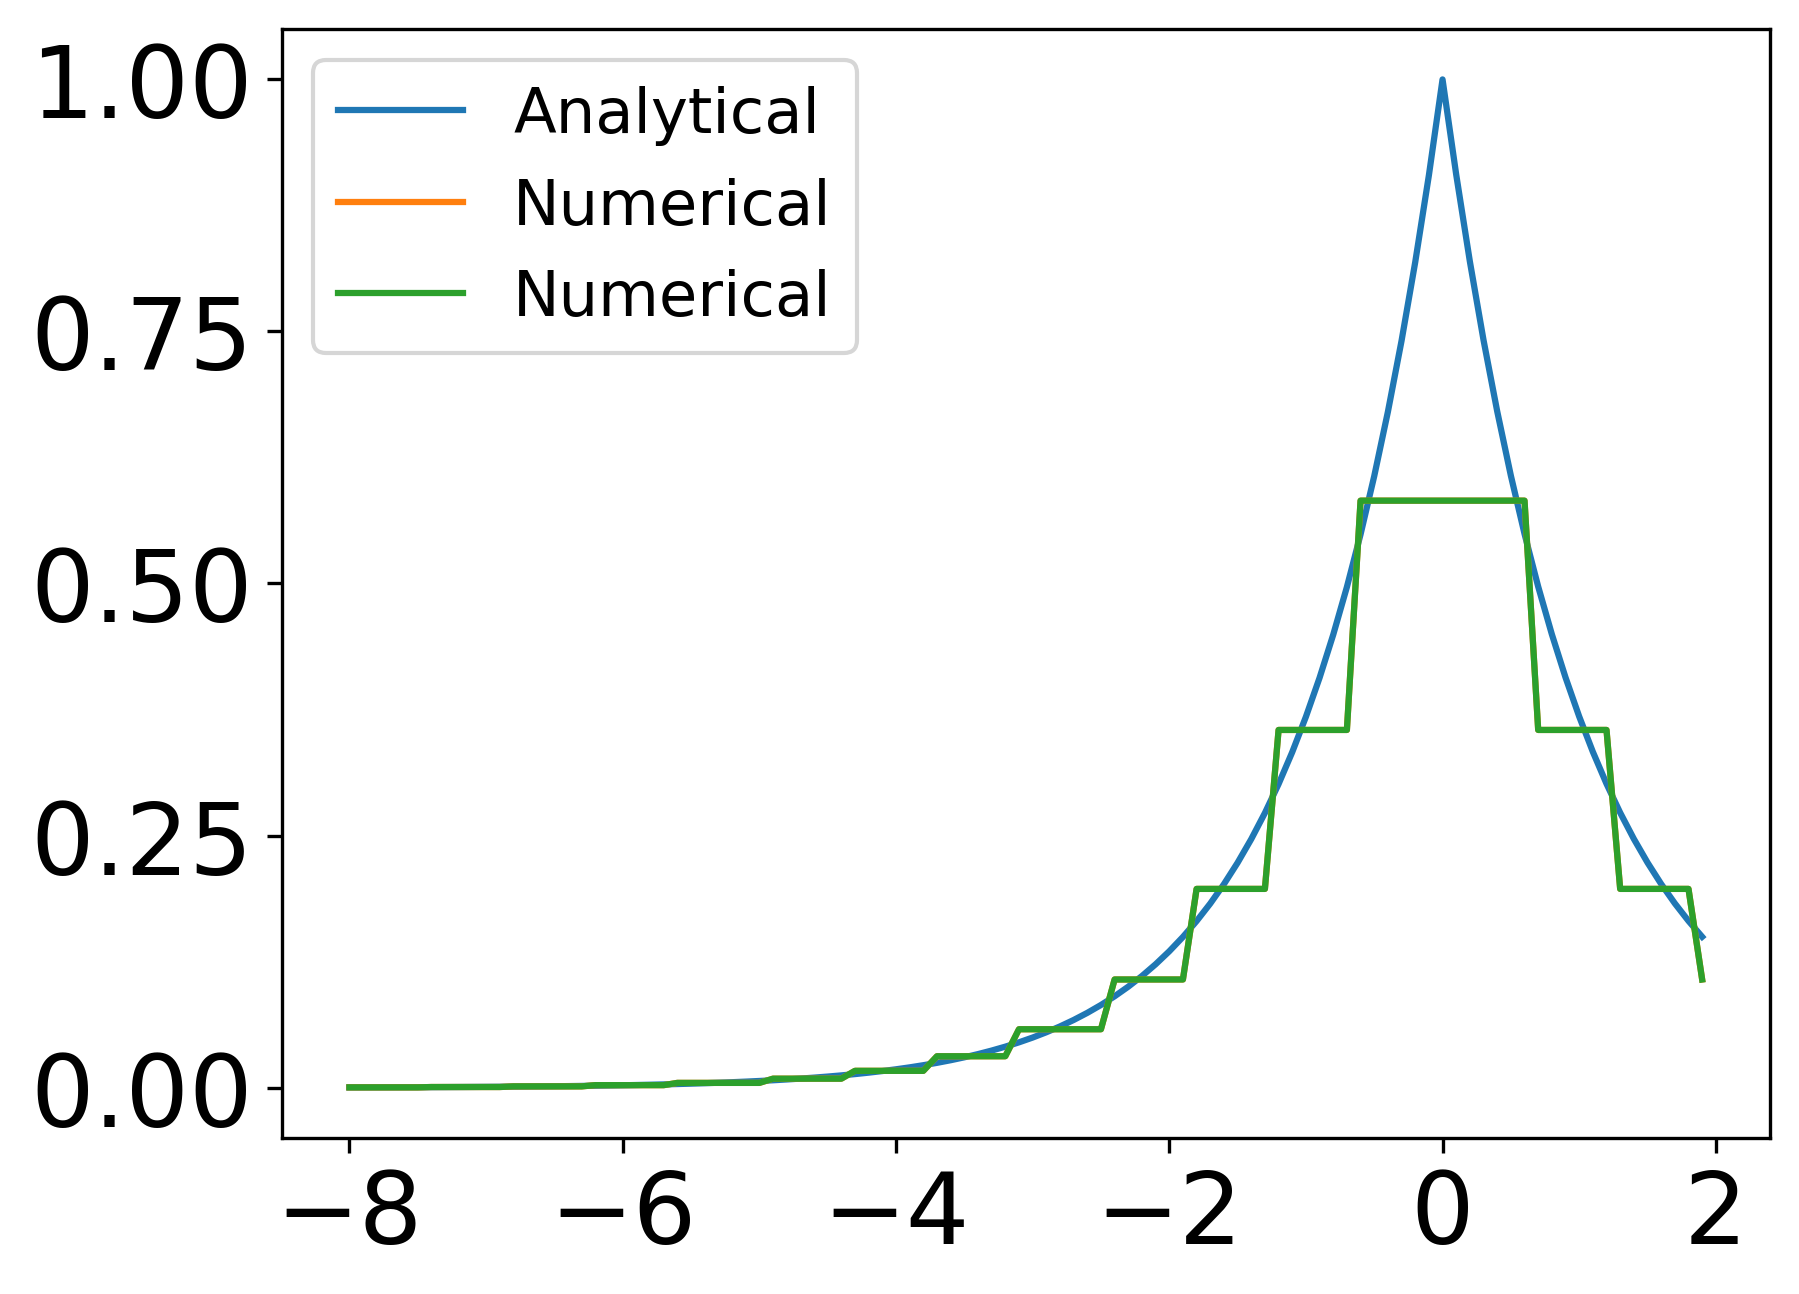

3.204978201475344e-05

In [211]:
# hp.ang2pix(NSIDE, theta=np.pi/2, phi=0) # figure out the index of the central sightline
selected_index = 24192
selected_index = hp.ang2pix(NSIDE, theta=np.pi/2, phi=0)
def anal_solution(r):
    res = np.exp(-np.abs(r))
    res[np.abs(r)>10] = 0
    return res

# cube_integral  = np.reshape(cube,(voxel_resolution**3))

plt.figure(dpi=300)
r_anal = np.linspace(np.min(x[:,selected_index]),np.max(x[:,selected_index]),100) # np.arange(-8,3,0.01)
plt.plot(r_anal, anal_solution(r_anal), label="Analytical")
plt.plot(x[:,selected_index], cube_integral[cube_indexes[:,selected_index]], label="Numerical")
plt.plot(x[:,selected_index], cube_integral_paths[:,selected_index], label="Numerical")
plt.xticks(np.arange(-8,3,2))
plt.legend(fontsize=15)
plt.savefig("../visuals/demo-analytical-vs-numerical-integral.svg", bbox_inches="tight")
plt.show()

np.sum(cube_integral[cube_indexes[:,selected_index]]) / (4*np.pi) * dl * dOmega

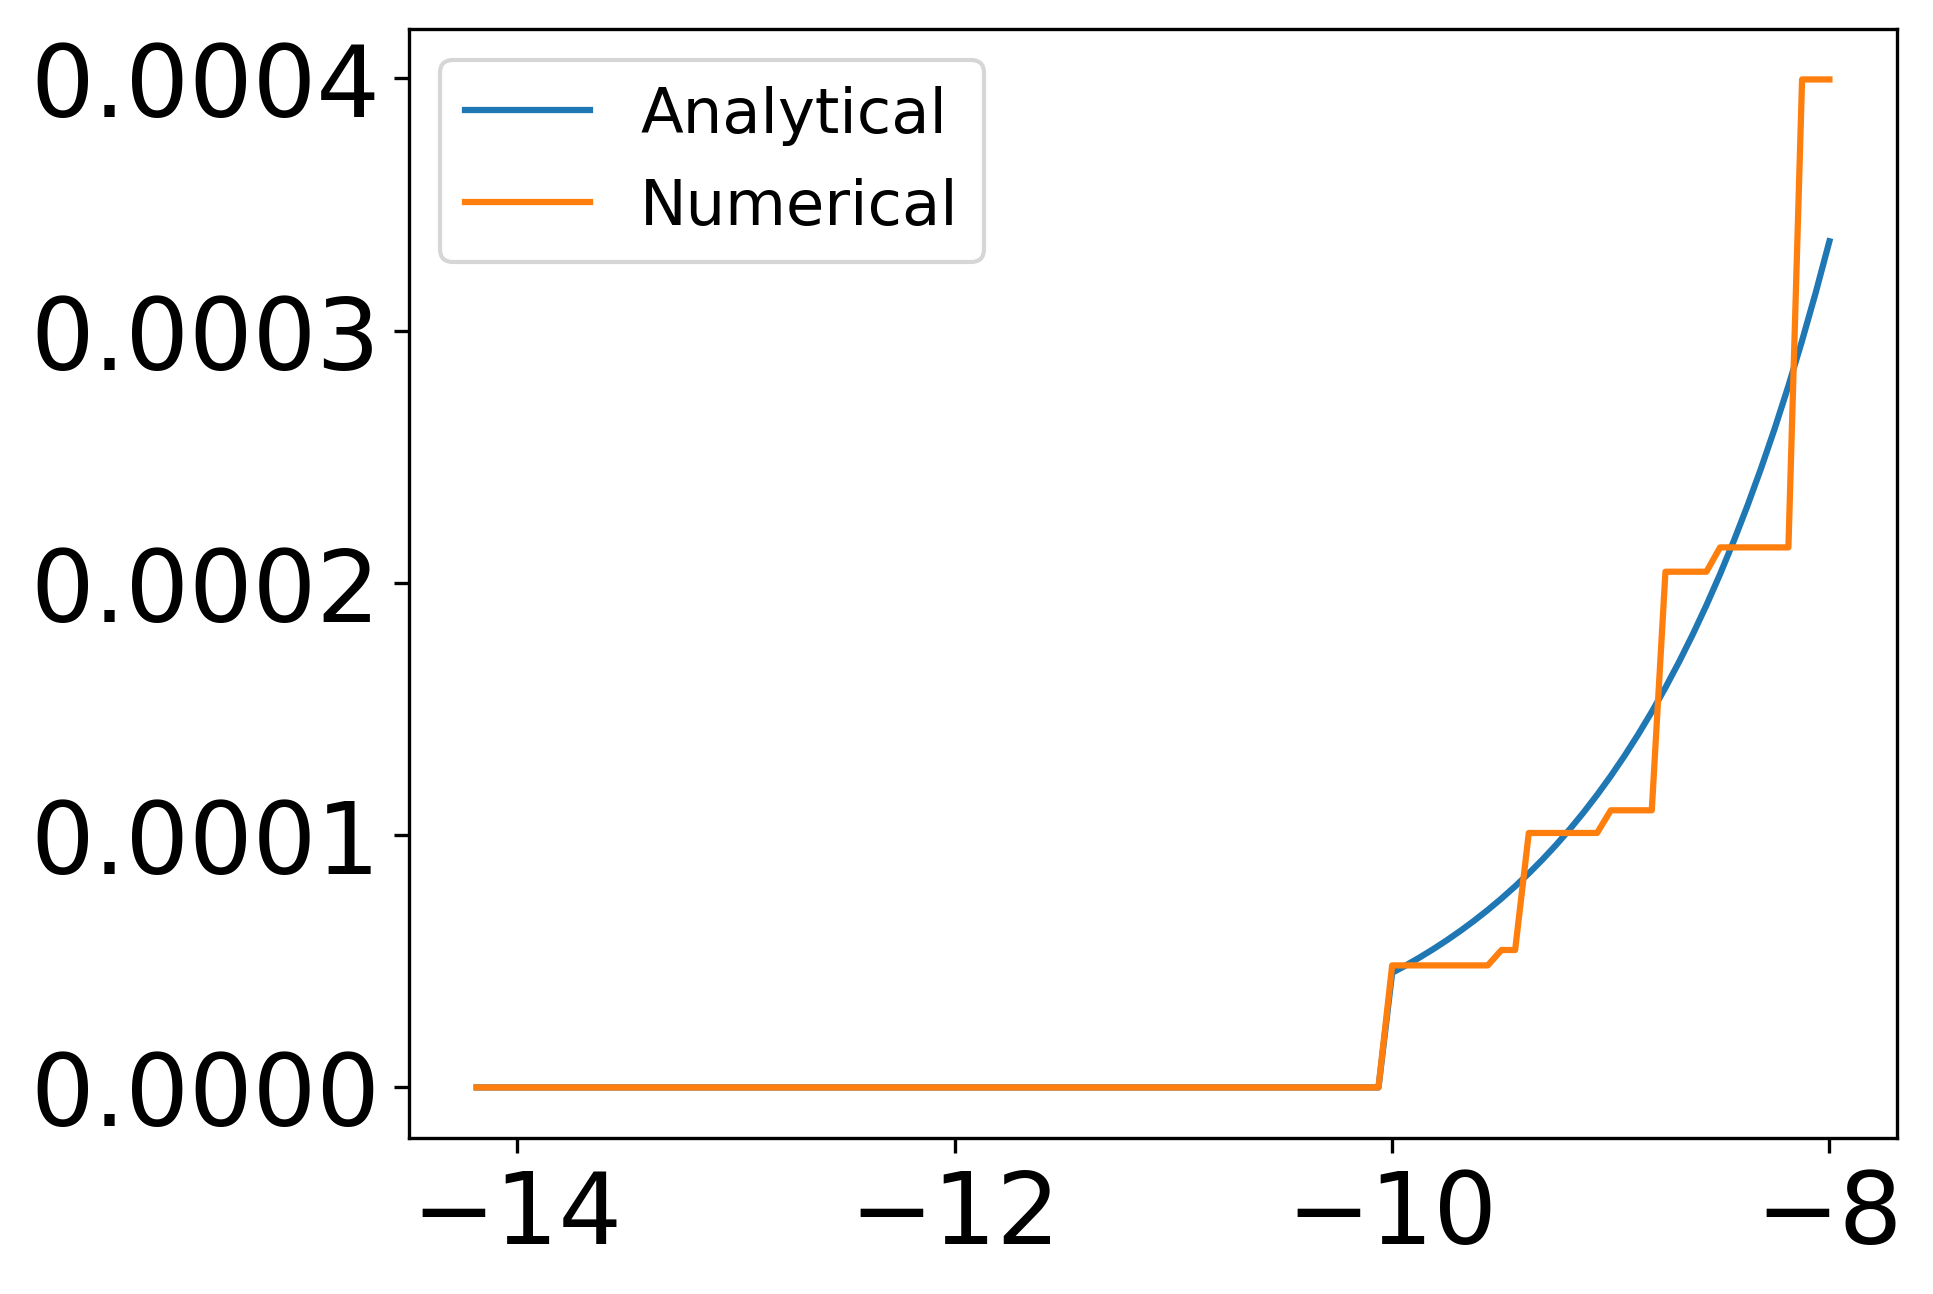

3.204978201475344e-05

In [223]:
# hp.ang2pix(NSIDE, theta=np.pi/2, phi=0) # figure out the index of the central sightline
selected_index = 24100
def anal_solution(r):
    res = np.exp(-np.abs(r))
    res[np.abs(r)>10] = 0
    return res

# cube_integral  = np.reshape(cube,(voxel_resolution**3))

plt.figure(dpi=300)
r_anal = np.linspace(np.min(x[:,selected_index]),np.max(x[:,selected_index]),100) # np.arange(-8,3,0.01)
plt.plot(r_anal, anal_solution(r_anal), label="Analytical")
# plt.plot(x[:,selected_index], cube_integral[cube_indexes[:,selected_index]], label="Numerical")
plt.plot(x[:,selected_index], cube_integral_paths[:,selected_index], label="Numerical")
# plt.xticks(np.arange(-8,3,2))
plt.legend(fontsize=15)
plt.savefig("../visuals/demo-analytical-vs-numerical-integral.svg", bbox_inches="tight")
plt.show()

np.sum(cube_integral[cube_indexes[:,24192]]) / (4*np.pi) * dl * dOmega

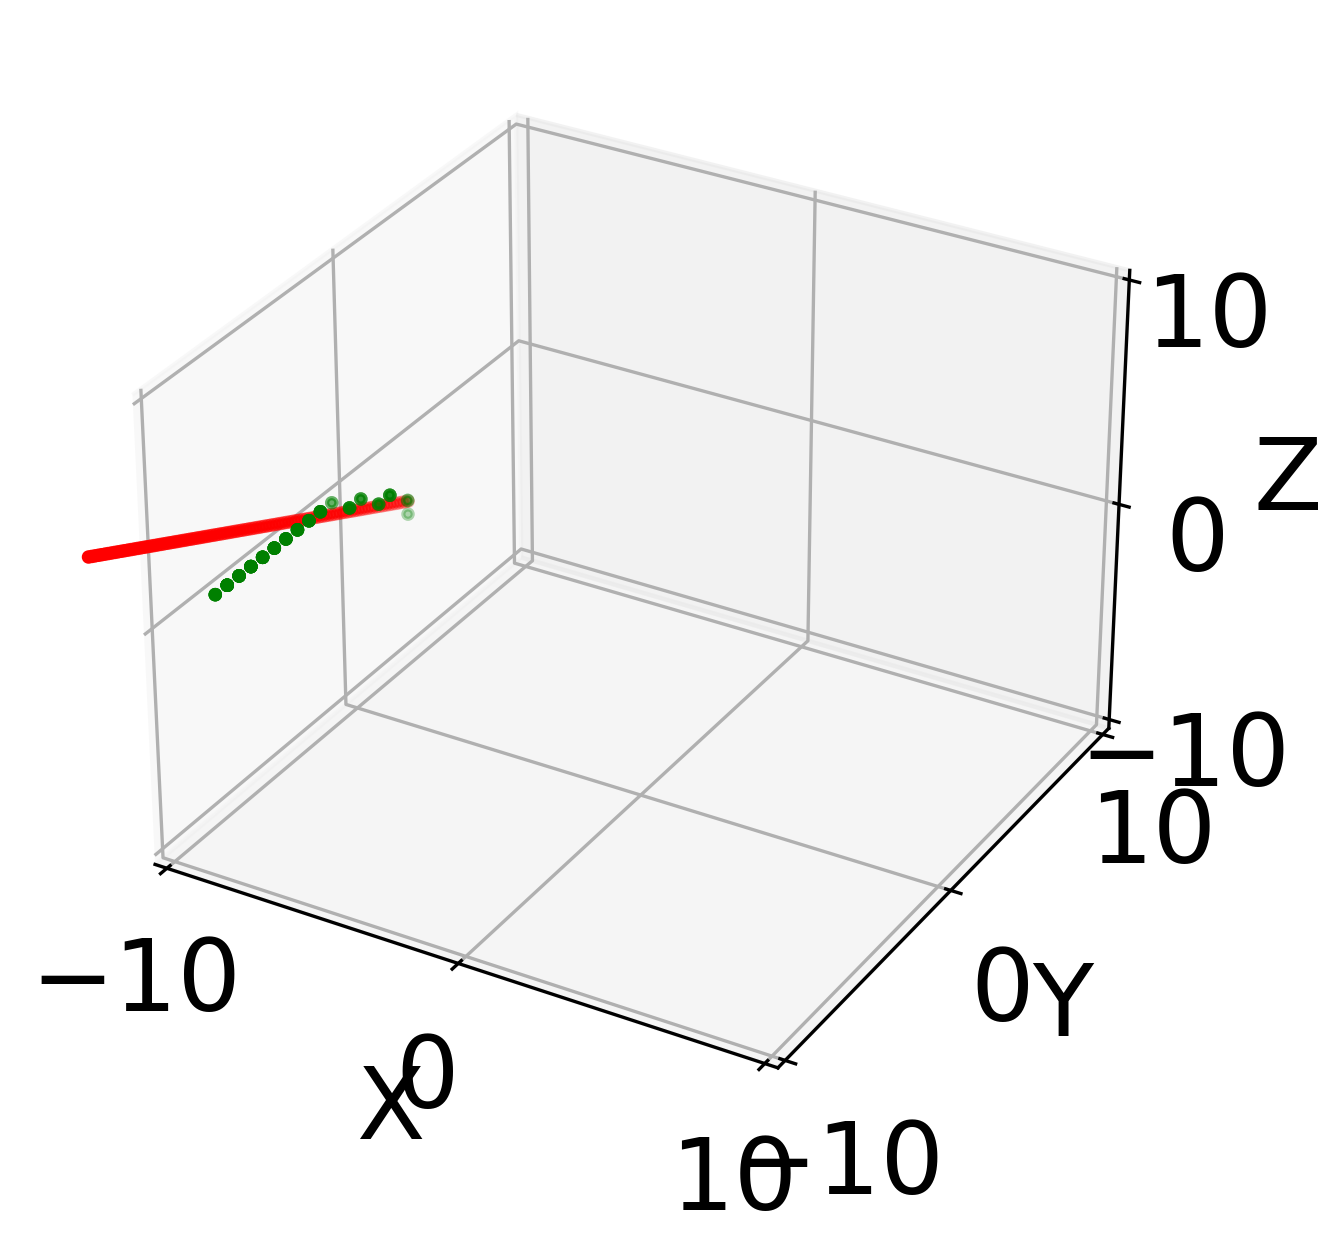

In [215]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(grid_coords[:, 0], grid_coords[:, 1], grid_coords[:, 2], c='b', marker='.')

# for i in range(768):
#     ax.scatter(x[:,i], y[:,i], z[:,i], c="r", marker='.')
i = 24192
i = 24100
ax.scatter(x[:,i], y[:,i], z[:,i], c="r", marker='.')
near_x, near_y, near_z = grid_coords[cube_indexes[:,i]][:,0], grid_coords[cube_indexes[:,i]][:,1], grid_coords[cube_indexes[:,i]][:,2]
ax.scatter(near_x, near_y, near_z, c="g", marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_zlim([-10,10])
plt.savefig("../visuals/demo-single-sightline.svg", bbox_inches="tight")
plt.show()

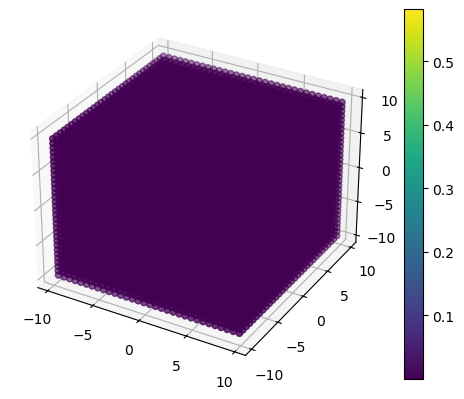

In [12]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(grid_coords[:,0], grid_coords[:,1], grid_coords[:,2], c=cube)
fig.colorbar(p)
plt.savefig("../visuals/demo-3D-exponential.svg", bbox_inches='tight')
plt.show()

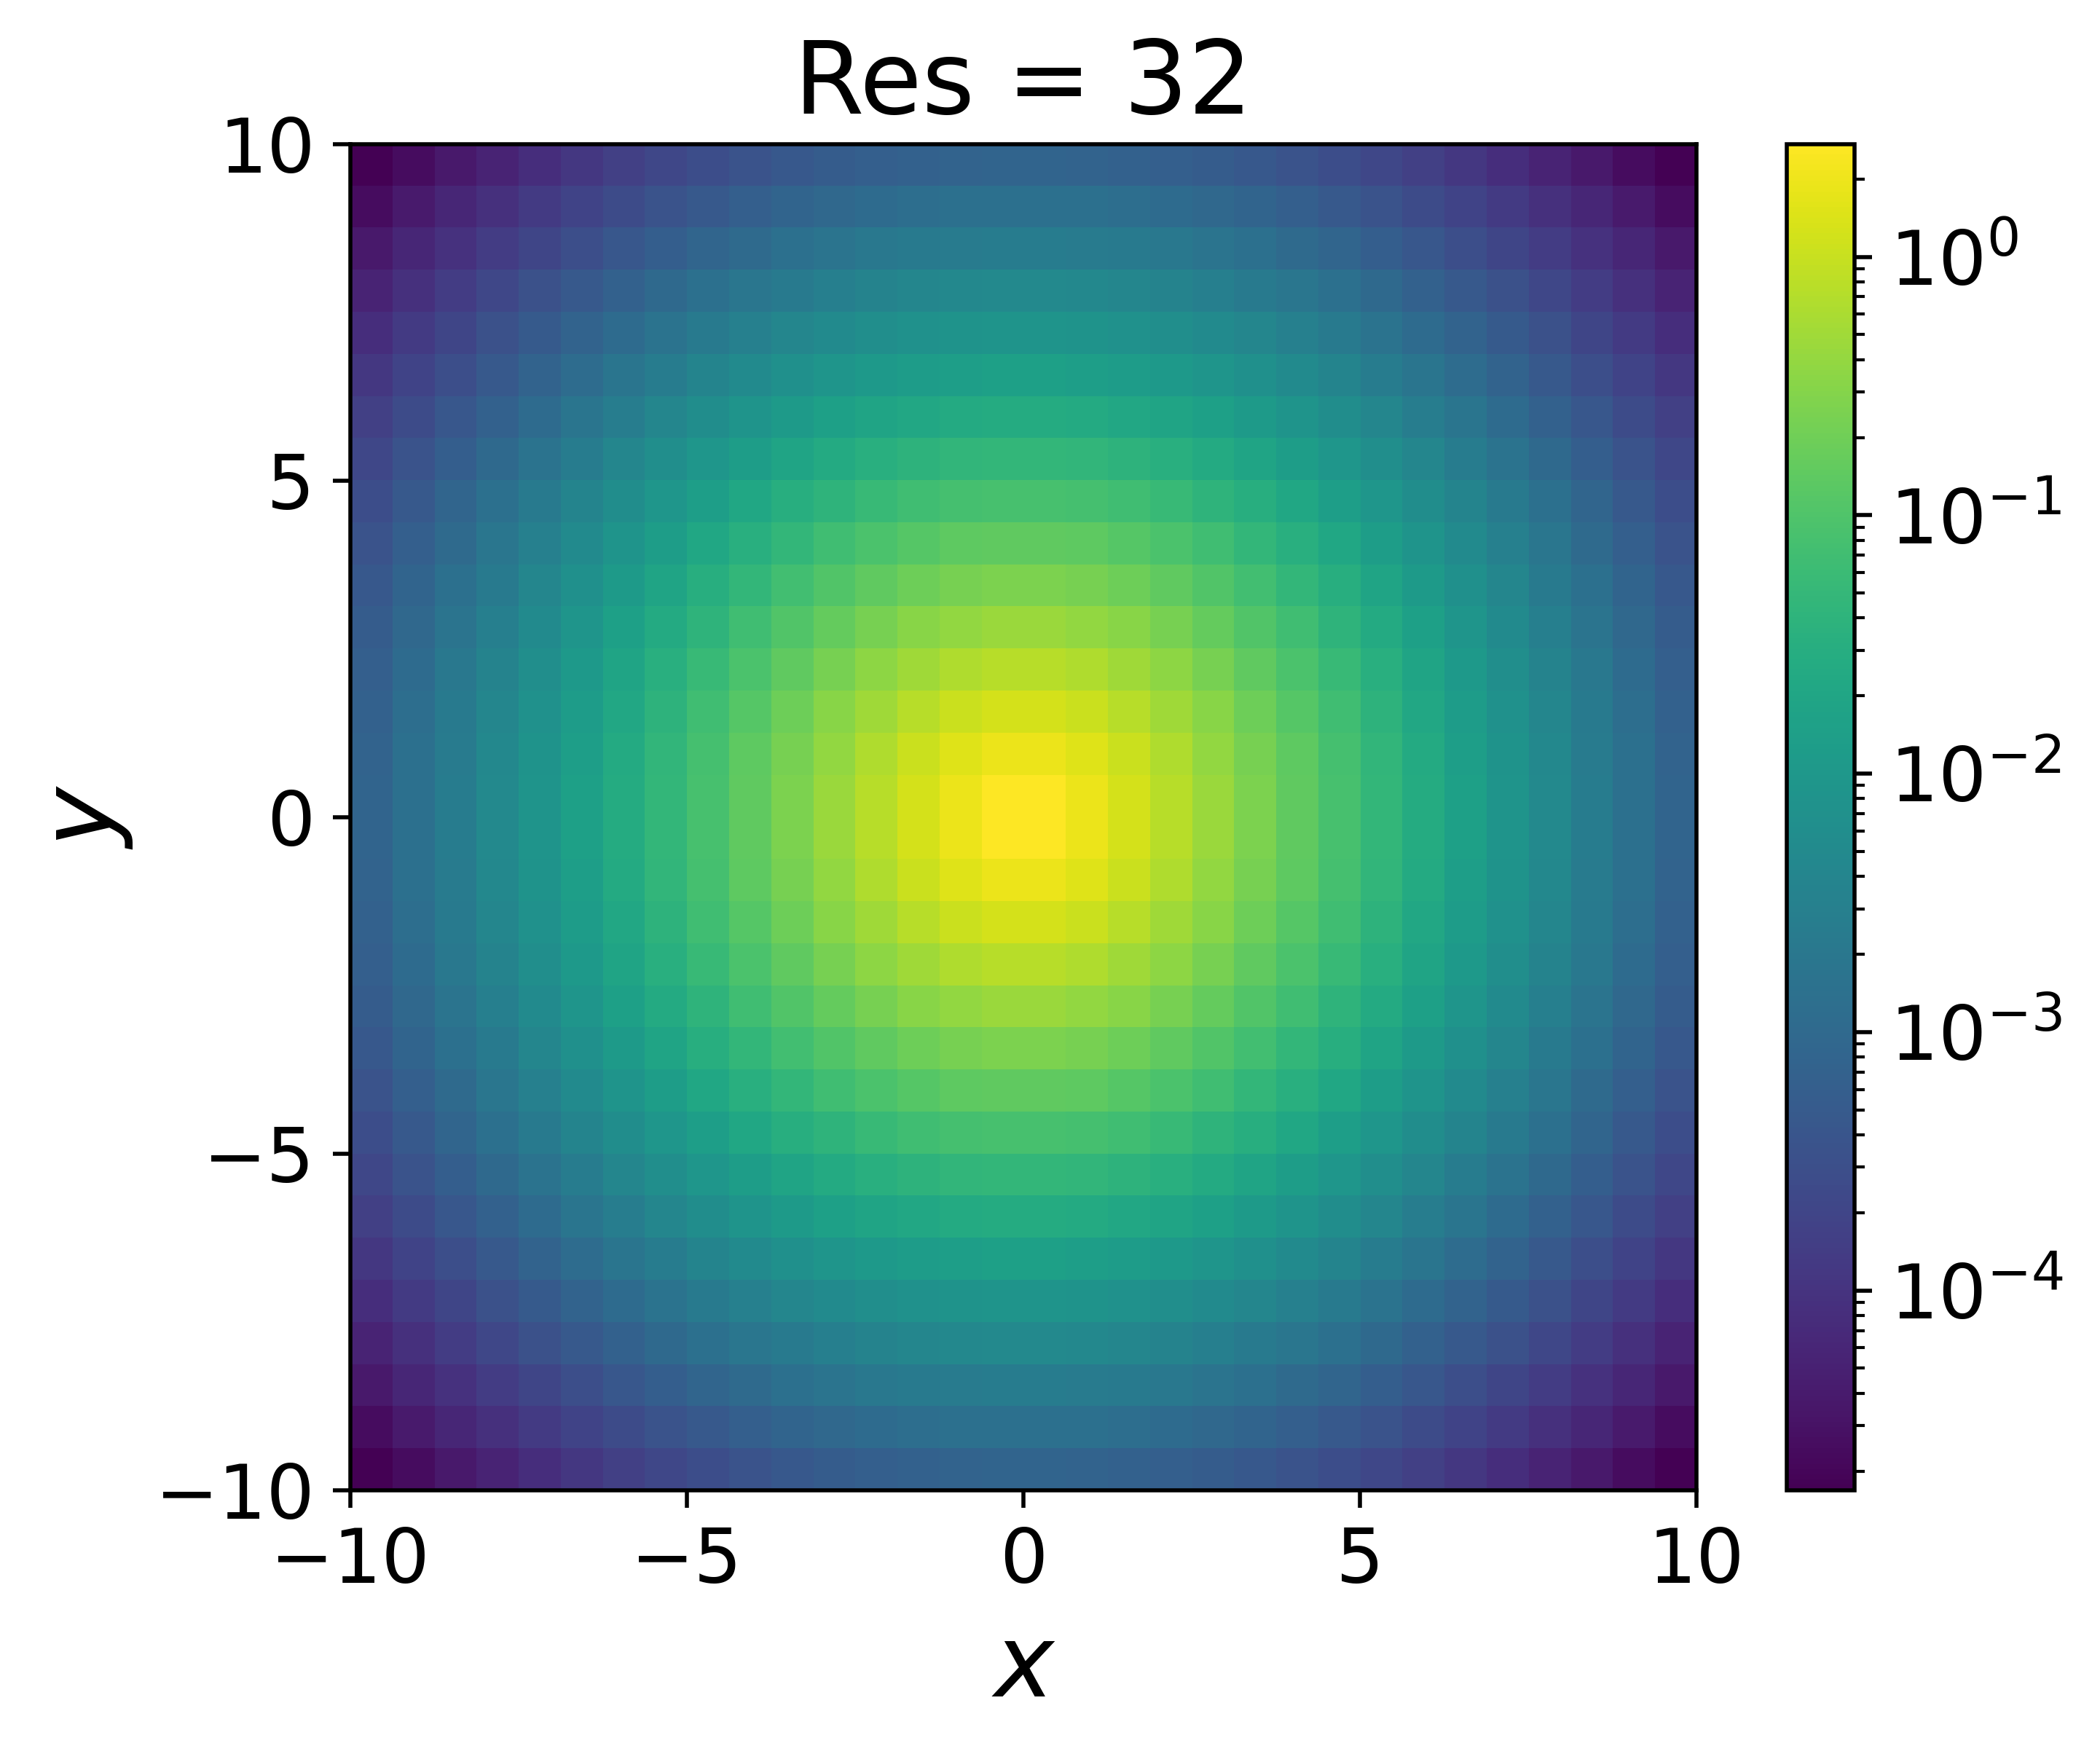

In [13]:
plot_cube(cube, "", "Res = "+str(voxel_resolution))

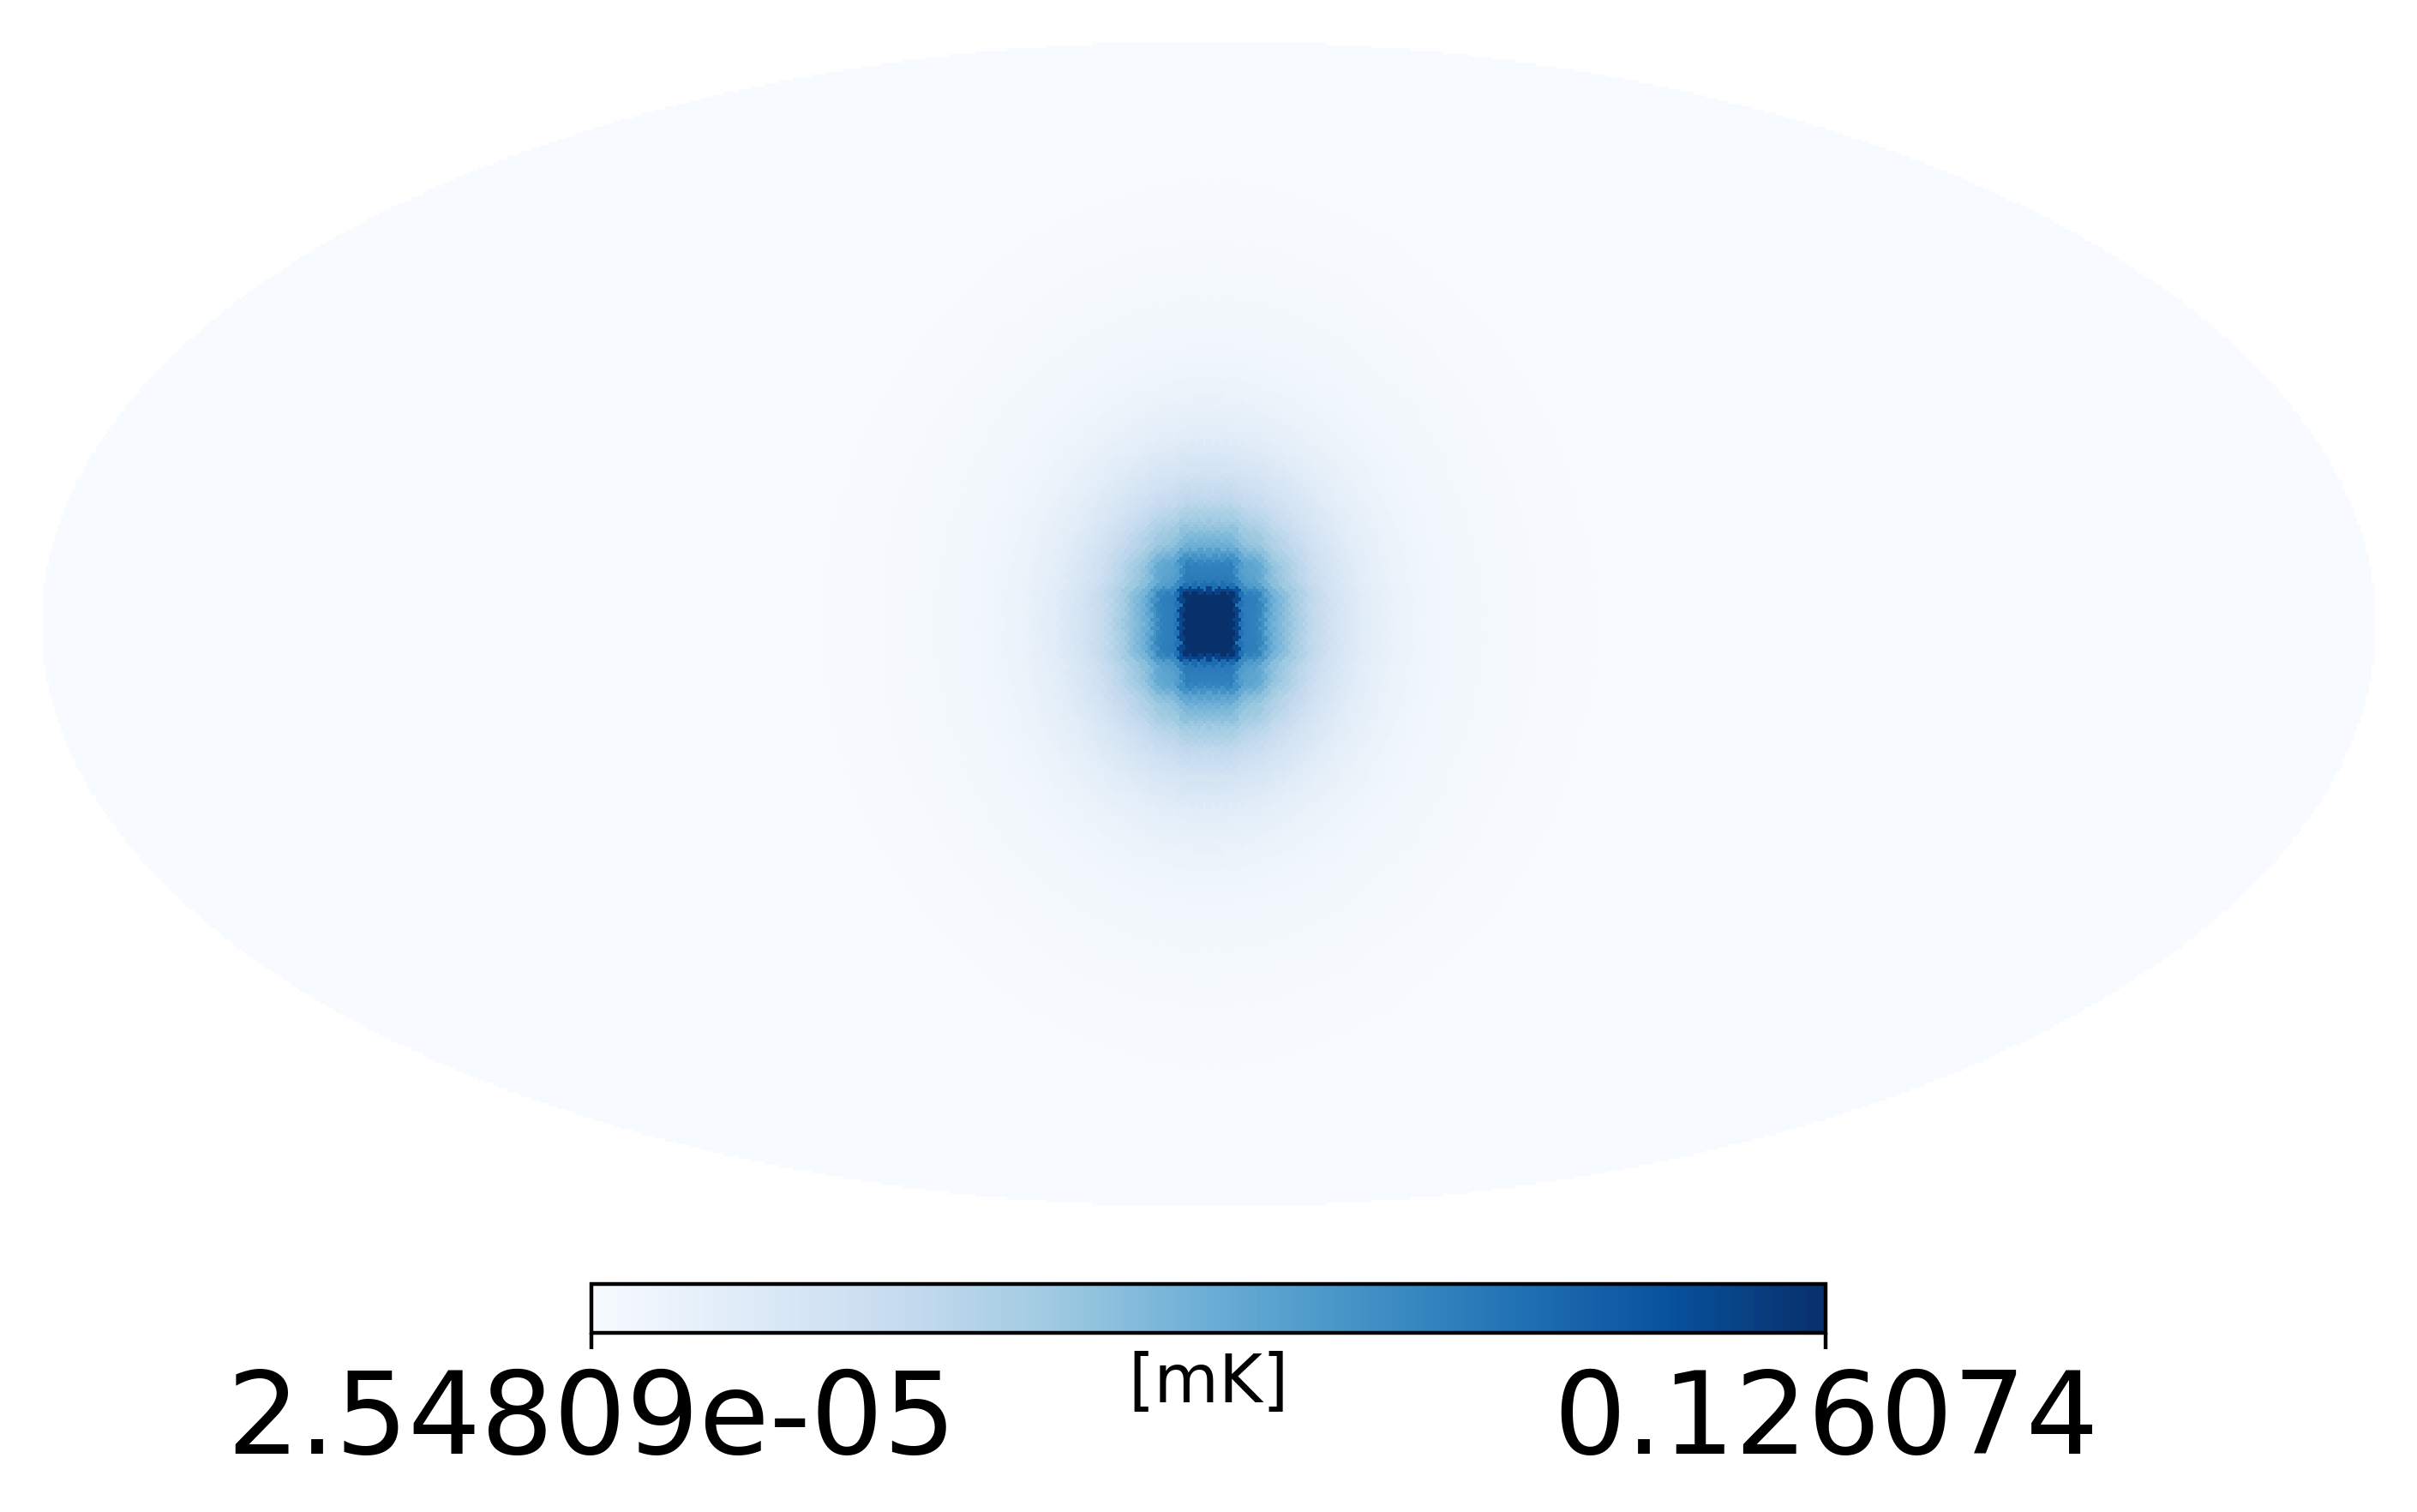

In [224]:
f1 = plt.figure(figsize=(7.5,4.5), dpi=400)
#wmaphaze[np.where(wmaphaze==0)] = -1000
# plot_wmaphaze = wmaphaze.copy()
# plot_wmaphaze[np.where(wmaphaze==0)] = np.nan
hp.mollview(f_aqn, 
            title="", 
            rot=(0,0,0),
            cmap='Blues', 
            fig=f1, 
            unit="[mK]", min = np.min(f_aqn), max = np.max(f_aqn)
            #min=-0.02,
            #max=270
           )
# plt.savefig("plots/MCMC-results/25k-april1/WMAP Haze Skymap.svg")
fontsize = 24
matplotlib.rcParams.update({'font.size':fontsize})

# save_name = "wmap-skymap-simulated"
# plt.savefig(save_name+".png", bbox_inches='tight')
# plt.savefig(save_name+".svg", bbox_inches='tight')
plt.show()

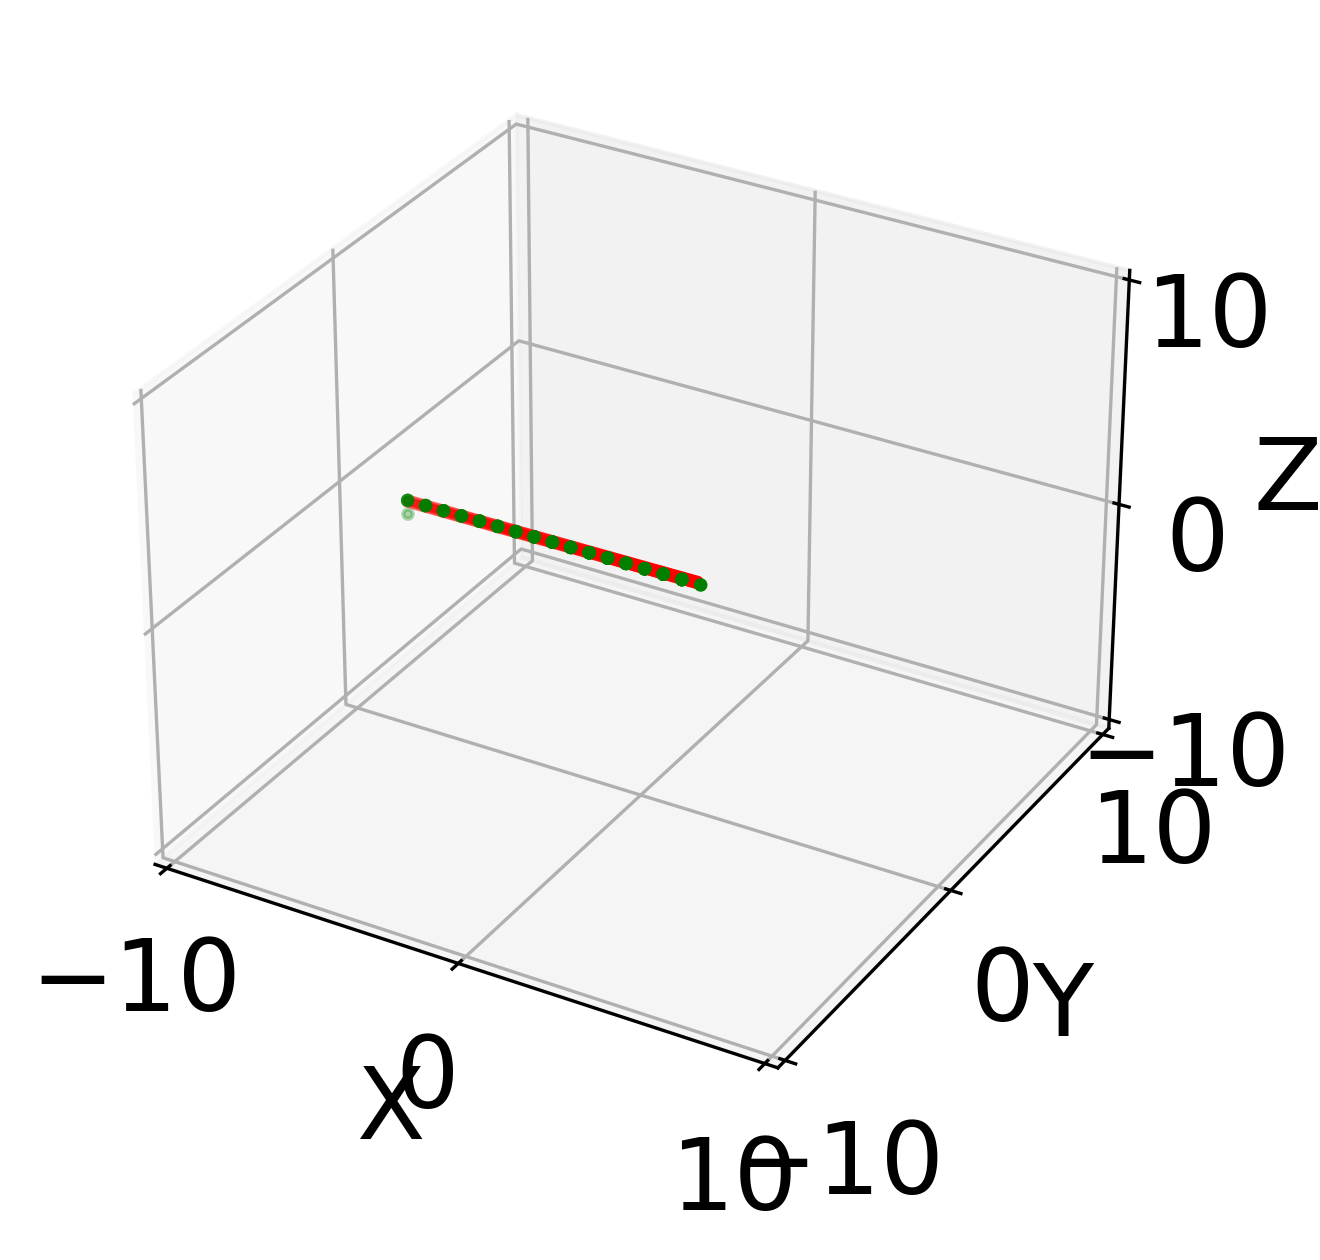

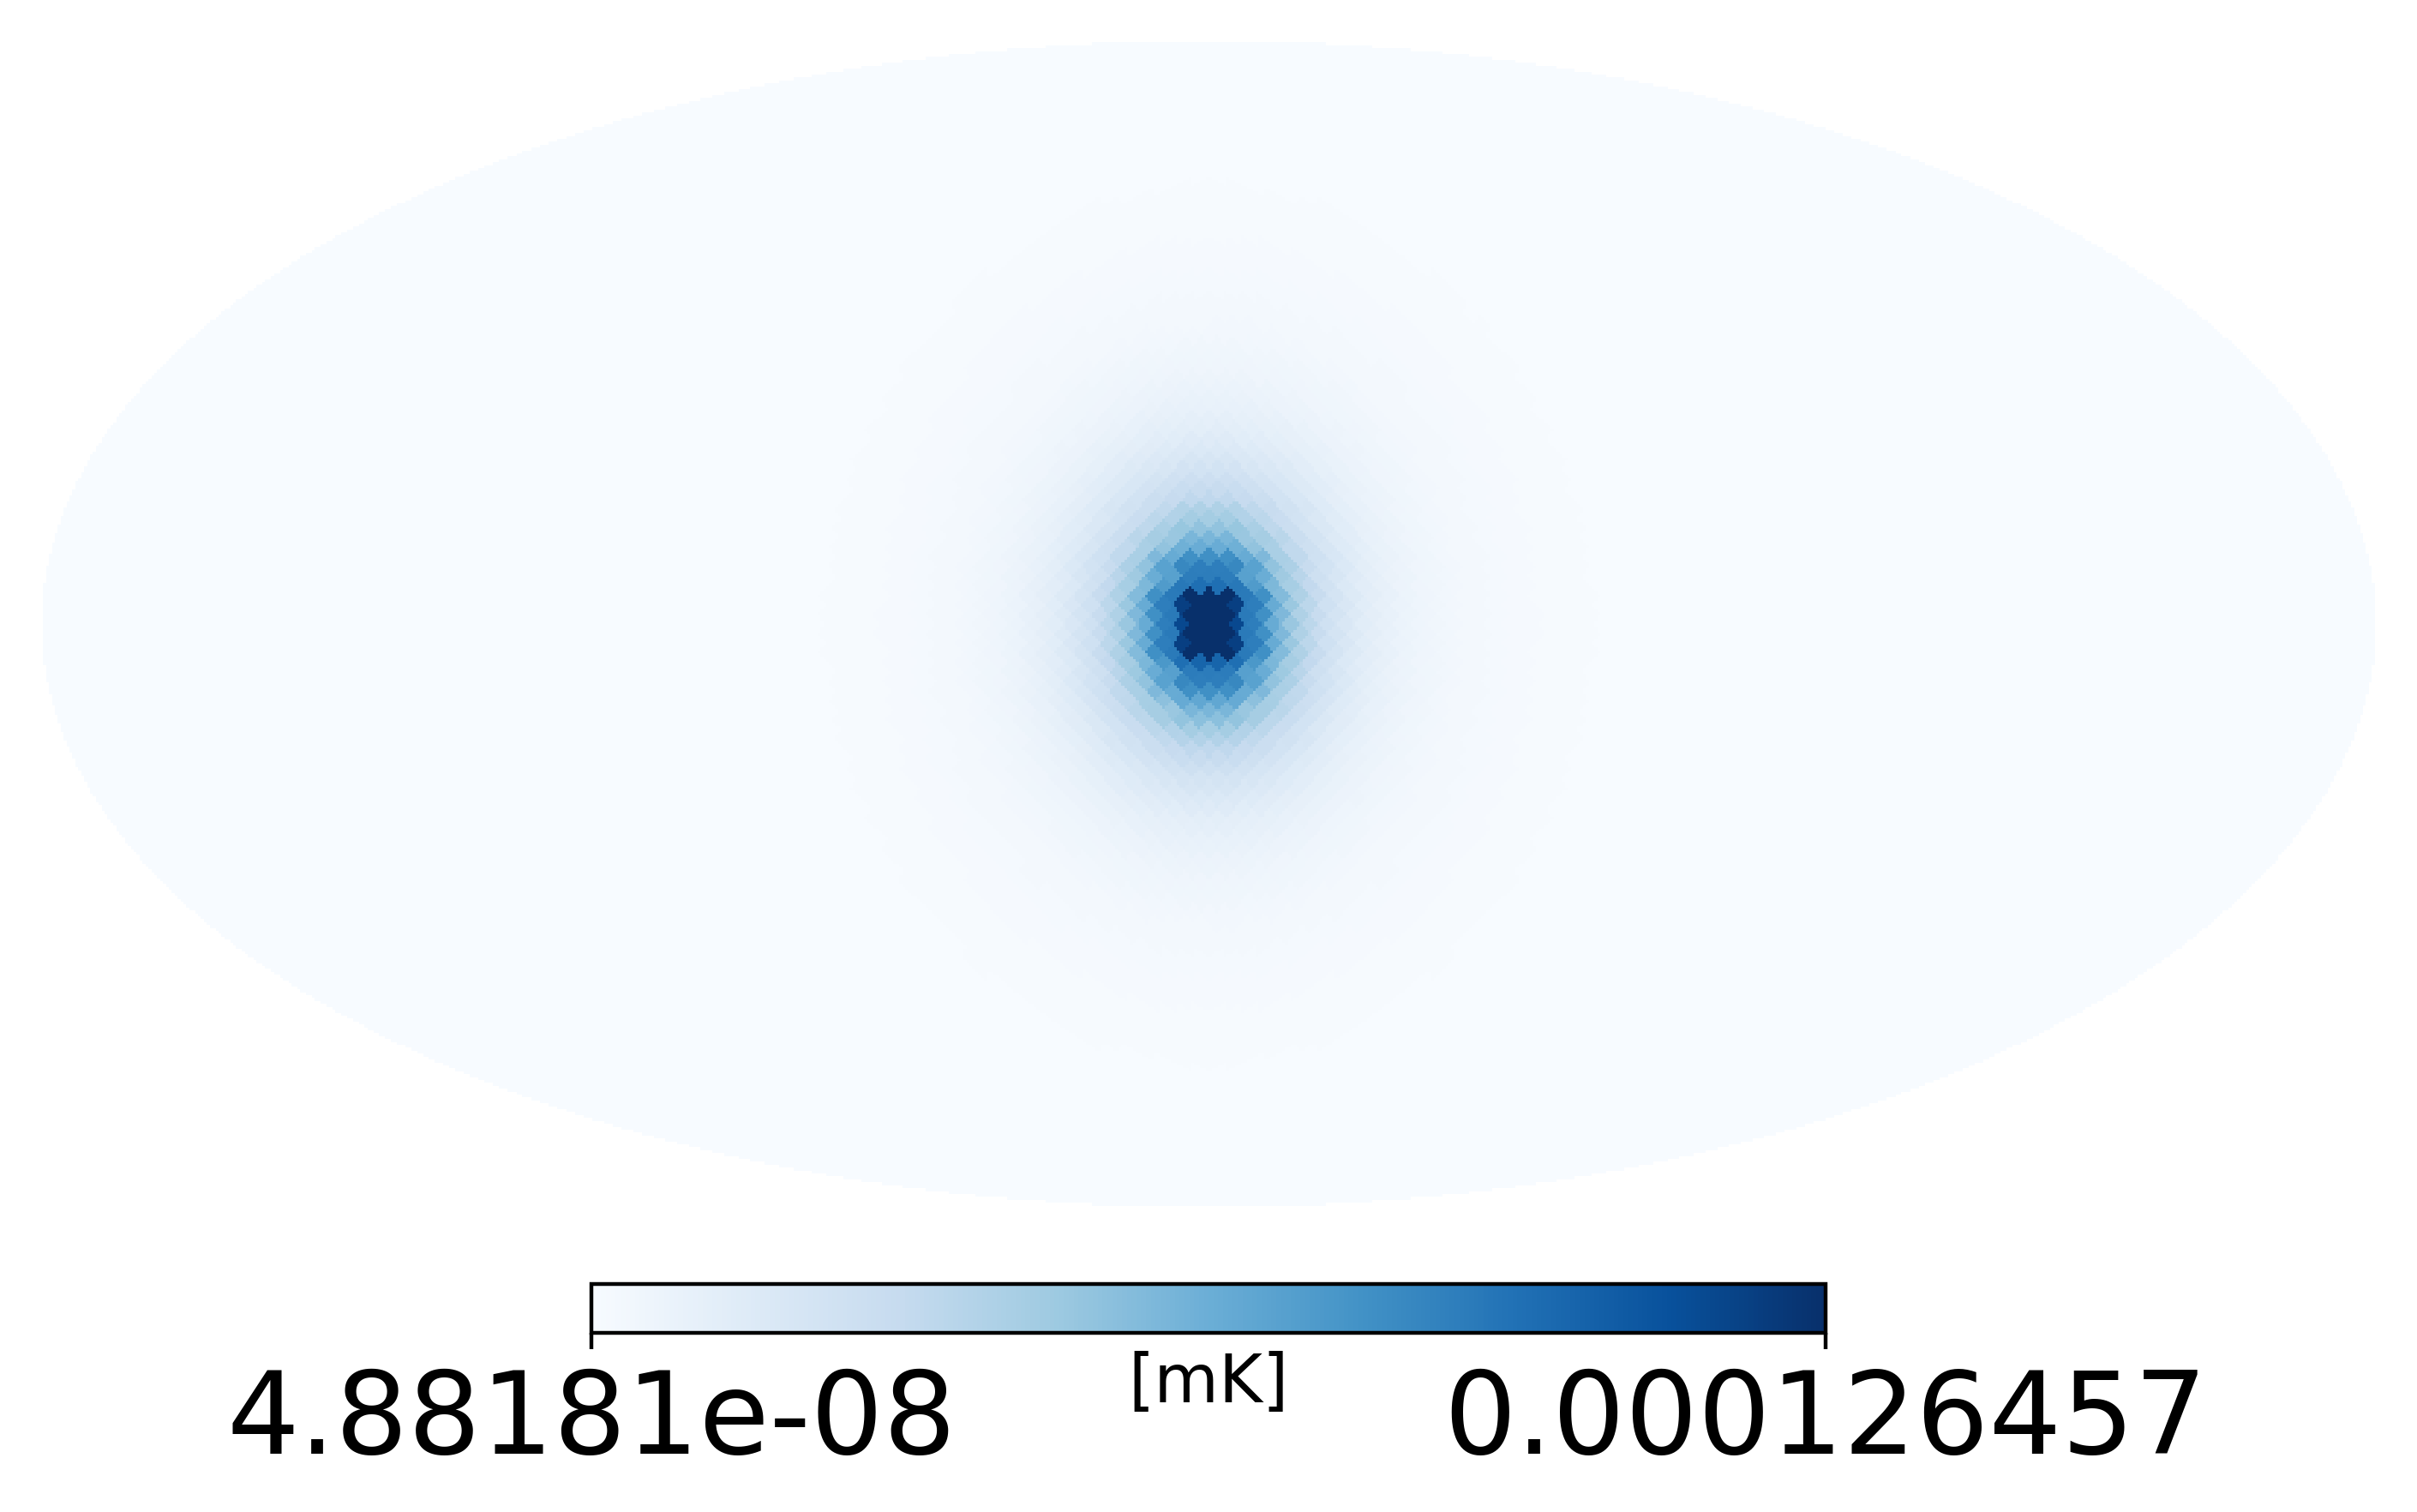